In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
!pip install np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 549 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=6dfd7e9bfbe65dc0bb56cc3718fe0f297ad3c8e504da8d2732d3b9395fb03a42
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils


In [6]:

import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
import tensorflow as tf
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

#**Importing dataset**


In [7]:

df1 = pd.read_csv('/content/drive/MyDrive/AI preparation/Sentiment_analysis/Twitter_Data.csv')
df2 = pd.read_csv('/content/drive/MyDrive/AI preparation/Sentiment_analysis/apple-twitter-sentiment-texts.csv')
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
df4 = pd.read_csv('/content/drive/MyDrive/AI preparation/Sentiment_analysis/Tweets.csv')
df4 = df4.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df4 = df4[['category','clean_text']]
df = pd.concat([df1,df2,df4], ignore_index=True)
df.isnull().sum()
df.dropna(axis=0, inplace=True)
df['category'] = df['category'].map({-1.0:'negative', 0.0:'neutral', 1.0:'positive'})
df = df.rename(columns={'clean_text':'text','category':'airline_sentiment'})
df.head()


,text,airline_sentiment
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


In [8]:
data = df[['text','airline_sentiment']]
data = data.dropna()
data.head()

,text,airline_sentiment
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp t...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


In [9]:
data.airline_sentiment.value_counts()

positive    74755
neutral     59111
negative    45373
Name: airline_sentiment, dtype: int64

#**Visualization of data**

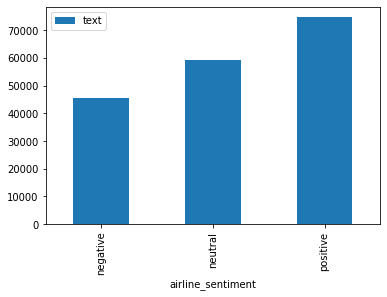

In [10]:
data.groupby('airline_sentiment').count().plot(kind='bar')

In [11]:
import plotly.express as px
fig = px.pie(data, names='airline_sentiment')
fig.show()

# **Data Preprocessing**

In [12]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['text'] = data['text'].apply(clean_text)


In [13]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 70
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 131802 unique tokens.


In [14]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (179239, 70)


In [15]:
Y = pd.get_dummies(data['airline_sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (179239, 3)


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(161315, 70) (161315, 3)
(17924, 70) (17924, 3)


# **Model building**

In [17]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 70, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

In [19]:
epochs = 30
batch_size = 64
earlystopping = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)
# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.3,
#                     callbacks=[earlystopping])

In [20]:
# import streamlit as st
import pickle
import numpy as np
load_model2=pickle.load(open('/content/drive/MyDrive/AI preparation/Sentiment_analysis/sentiment_model_pickle.pkl','rb'))

In [21]:
load_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 70, 100)           5000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 70, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                      

In [22]:
accr = load_model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

561/561 [==============================] - 14s 24ms/step - loss: 0.7446 - accuracy: 0.8673
Test set
  Loss: 0.745
  Accuracy: 0.867


In [23]:
! pip install -q gradio


     |████████████████████████████████| 5.3 MB 7.2 MB/s 
     |████████████████████████████████| 56 kB 3.5 MB/s 
     |████████████████████████████████| 212 kB 50.3 MB/s 
     |████████████████████████████████| 84 kB 2.1 MB/s 
     |████████████████████████████████| 272 kB 41.0 MB/s 
     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 106 kB 76.2 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 2.3 MB 43.5 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 8.5 MB/s 
     |████████████████████████████████| 68 kB 5.5 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 856 kB 66.2 MB/s 
     |████████████████████████████████| 4.0 MB 44.5 MB/s 
     |████████████████████████████████| 593 kB 37.6 MB/s 


In [24]:
def result2(input_text):
  input_text = [input_text]
  
  seq = tokenizer.texts_to_sequences(input_text)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = load_model2.predict(padded)
  labels = ['negative','neutral','positive']
  percent_value = np.max(pred)*100
  percent_value1='{0:.{1}f}'.format(percent_value, 2)
  # print(percent_value1)
  # print(labels[np.argmax(pred)])
  # return 'The sentence is '+str(labels[np.argmax(pred)])+' with  '+percent_value1+'% accuracy'
  return 'The sentence is '+str(labels[np.argmax(pred)]),'accuracy:  '+percent_value1+'%'


sentence = 'food is worst '
emotion,v = result2(sentence)
print(emotion)
print(v)


1/1 [==============================] - 0s 337ms/step
The sentence is negative
accuracy:  99.94%


# **Deploying using Gradio app**

In [25]:
import gradio as gr
iface = gr.Interface( fn=result2, inputs='text',outputs = ['text','text'], title = 'sentiment analysis',
                     allow_flagging="never")
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://6a2927cac19be577.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f7993c67790>,
 'http://127.0.0.1:7860/',
 'https://6a2927cac19be577.gradio.app')